# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import cv2
from tqdm import tqdm
import datetime
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate 
from tensorflow.keras.layers import Input, Add, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
%matplotlib inline

from IPython.display import HTML
from base64 import b64encode

2024-05-28 22:01:06.355076: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 22:01:06.627660: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 22:01:08.344741: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_data_dir = r'/home/ashok/Desktop/github project/Road-lane-line-detection/data/test_images/'
TRAINSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.8)
print(f"Number of Training Examples: {TRAINSET_SIZE}")

VALIDSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.1)
print(f"Number of Validation Examples: {VALIDSET_SIZE}")

TESTSET_SIZE = int(len(os.listdir(train_data_dir)) - TRAINSET_SIZE - VALIDSET_SIZE)
print(f"Number of Testing Examples: {TESTSET_SIZE}")


Number of Training Examples: 236
Number of Validation Examples: 29
Number of Testing Examples: 31


In [3]:
IMG_SIZE = 128
N_CHANNELS = 3
N_CLASSES = 1
SEED = 123


In [4]:
def parse_image(img_path: str) -> dict:
    image = tf.io.read_file(train_data_dir+'example1.jpg')
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # Three types of img paths: um, umm, uu
    # gt image paths: um_road, umm_road, uu_road
    mask_path = tf.strings.regex_replace(img_path, "image_2", "gt_image_2")
    mask_path = tf.strings.regex_replace(mask_path, "um_", "um_road_")
    mask_path = tf.strings.regex_replace(mask_path, "umm_", "umm_road_")
    mask_path = tf.strings.regex_replace(mask_path, "uu_", "uu_road_")
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    
    non_road_label = np.array([255, 0, 0])
    road_label = np.array([255, 0, 255])
    other_road_label = np.array([0, 0, 0])
    
    # Convert to mask to binary mask
    mask = tf.experimental.numpy.all(mask == road_label, axis = 2)
    mask = tf.cast(mask, tf.uint8)
    mask = tf.expand_dims(mask, axis=-1)

    return {'image': image, 'segmentation_mask': mask}

# Generate dataset variables
all_dataset = tf.data.Dataset.list_files(train_data_dir+ "*.png", seed=SEED)
all_dataset = all_dataset.map(parse_image)

train_dataset = all_dataset.take(TRAINSET_SIZE + VALIDSET_SIZE)
val_dataset = train_dataset.skip(TRAINSET_SIZE)
train_dataset = train_dataset.take(TRAINSET_SIZE)
test_dataset = all_dataset.skip(TRAINSET_SIZE + VALIDSET_SIZE)



In [5]:
# Generate dataset variables
all_dataset = tf.data.Dataset.list_files(train_data_dir + "*.png", seed=SEED)
all_dataset = all_dataset.map(parse_image)

train_dataset = all_dataset.take(TRAINSET_SIZE + VALIDSET_SIZE)
val_dataset = train_dataset.skip(TRAINSET_SIZE)
train_dataset = train_dataset.take(TRAINSET_SIZE)
test_dataset = all_dataset.skip(TRAINSET_SIZE + VALIDSET_SIZE)

In [6]:
# Tensorflow function to rescale images to [0, 1]
@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

# Tensorflow function to apply preprocessing transformations
@tf.function
def load_image_train(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

# Tensorflow function to preprocess validation images
@tf.function
def load_image_test(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [7]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

dataset = {"train": train_dataset, "val": val_dataset, "test": test_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=tf.data.AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=tf.data.AUTOTUNE)

#-- Testing Dataset --#
dataset['test'] = dataset['test'].map(load_image_test)
dataset['test'] = dataset['test'].batch(BATCH_SIZE)
dataset['test'] = dataset['test'].prefetch(buffer_size=tf.data.AUTOTUNE)

print(dataset['train'])
print(dataset['val'])
print(dataset['test'])

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


2024-05-28 22:01:16.714942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


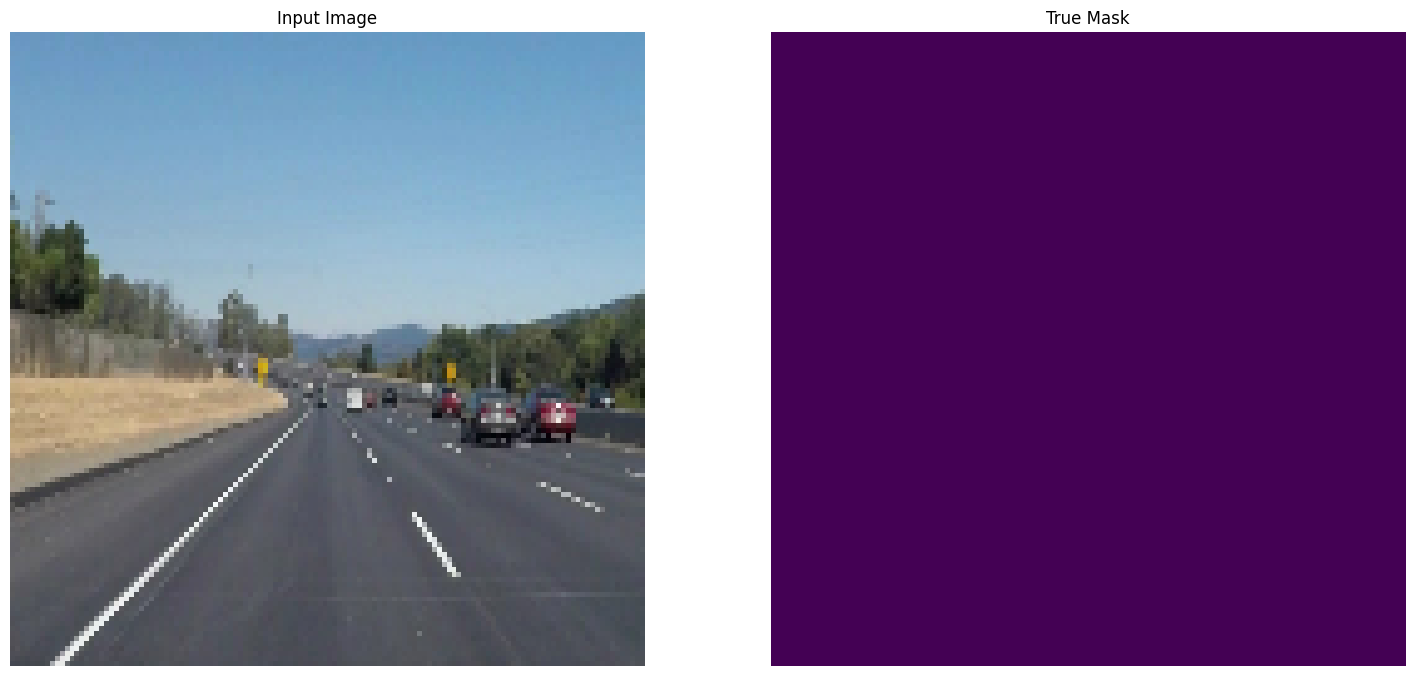

In [8]:
# Function to view the images from the directory
def display_sample(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.show()
    
for image, mask in dataset["train"].take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]])


In [9]:
vgg16_model = VGG16()
vgg16_model.summary()


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
input_shape = (IMG_SIZE, IMG_SIZE, N_CHANNELS)

In [11]:
# Generate a new model using the VGG network
# Input
inputs = Input(input_shape)

# VGG network
vgg16_model = VGG16(include_top = False, weights = 'imagenet', input_tensor = inputs)

# Encoder Layers
c1 = vgg16_model.get_layer("block3_pool").output         
c2 = vgg16_model.get_layer("block4_pool").output         
c3 = vgg16_model.get_layer("block5_pool").output         

# Decoder
u1 = UpSampling2D((2, 2), interpolation = 'bilinear')(c3)
d1 = Concatenate()([u1, c2])

u2 = UpSampling2D((2, 2), interpolation = 'bilinear')(d1)
d2 = Concatenate()([u2, c1])

# Output
u3 = UpSampling2D((8, 8), interpolation = 'bilinear')(d2)
outputs = Conv2D(N_CLASSES, 1, activation = 'sigmoid')(u3)

model = Model(inputs, outputs, name = "VGG_FCN8")

## Training

In [12]:
m_iou = tf.keras.metrics.MeanIoU(2)
model.compile(optimizer=Adam(),
              loss=BinaryCrossentropy(),
              metrics=[m_iou])

2024-05-28 22:06:11.925380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


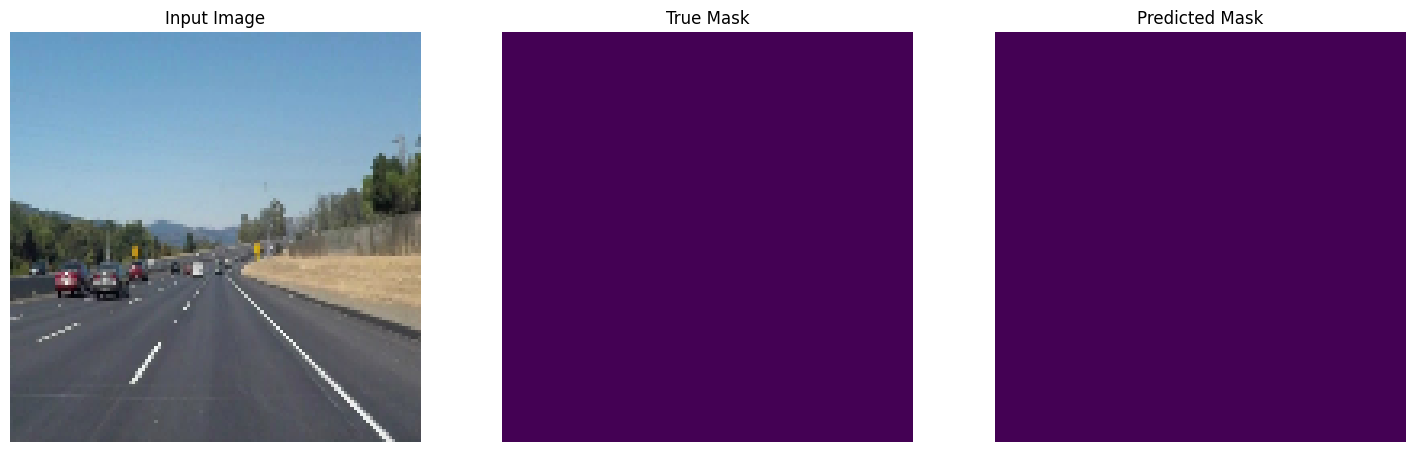

In [16]:
# Function to create a mask out of network prediction
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    # Round to closest
    pred_mask = tf.math.round(pred_mask)
    
    # [IMG_SIZE, IMG_SIZE] -> [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

# Function to show predictions
def show_predictions(dataset=None, num=1):
    if dataset:
        # Predict and show image from input dataset
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], true_mask, create_mask(pred_mask)])
    else:
        # Predict and show the sample image
        inference = model.predict(sample_image)
        display_sample([sample_image[0], sample_mask[0],
                        inference[0]])
        
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

show_predictions()

In [14]:
# Callbacks and Logs
class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks = [
    DisplayCallback(),
    callbacks.TensorBoard(logdir, histogram_freq = -1),
    callbacks.EarlyStopping(patience = 10, verbose = 1),
    callbacks.ModelCheckpoint('best_model.keras', verbose = 1, save_best_only = True)
]
        
# Set Variables
EPOCHS = 200
STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALIDSET_SIZE // BATCH_SIZE


In [17]:
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data = dataset["val"],
                          validation_steps=VALIDATION_STEPS,
                          callbacks = callbacks)

Epoch 1/200


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 0.0000e+00 - mean_io_u: 1.0000

KeyboardInterrupt: 

## Testing (Test Dataset)

In [ ]:
# Function to calculate mask over image
def weighted_img(img, initial_img, α=1., β=0.5, γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

# Function to process an individual image and it's mask
def process_image_mask(image, mask):
    # Round to closest
    mask = tf.math.round(mask)
    
    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image))
    mask = np.asarray(mask, np.float32)
    
    # Convert to image image
    image = np.asarray(image, np.float32)
    
    # Get the final image
    final_image = weighted_img(mask, image)

    return final_image

Processing image : 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


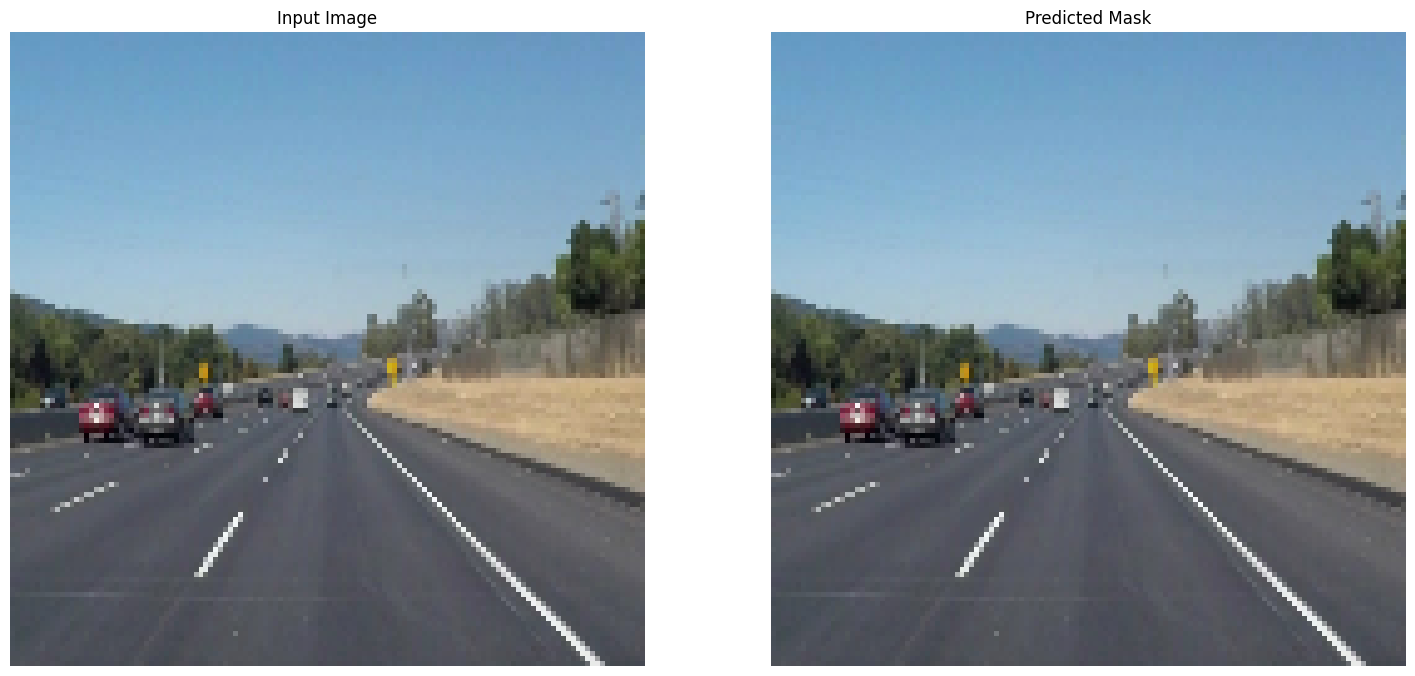

Processing image : 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


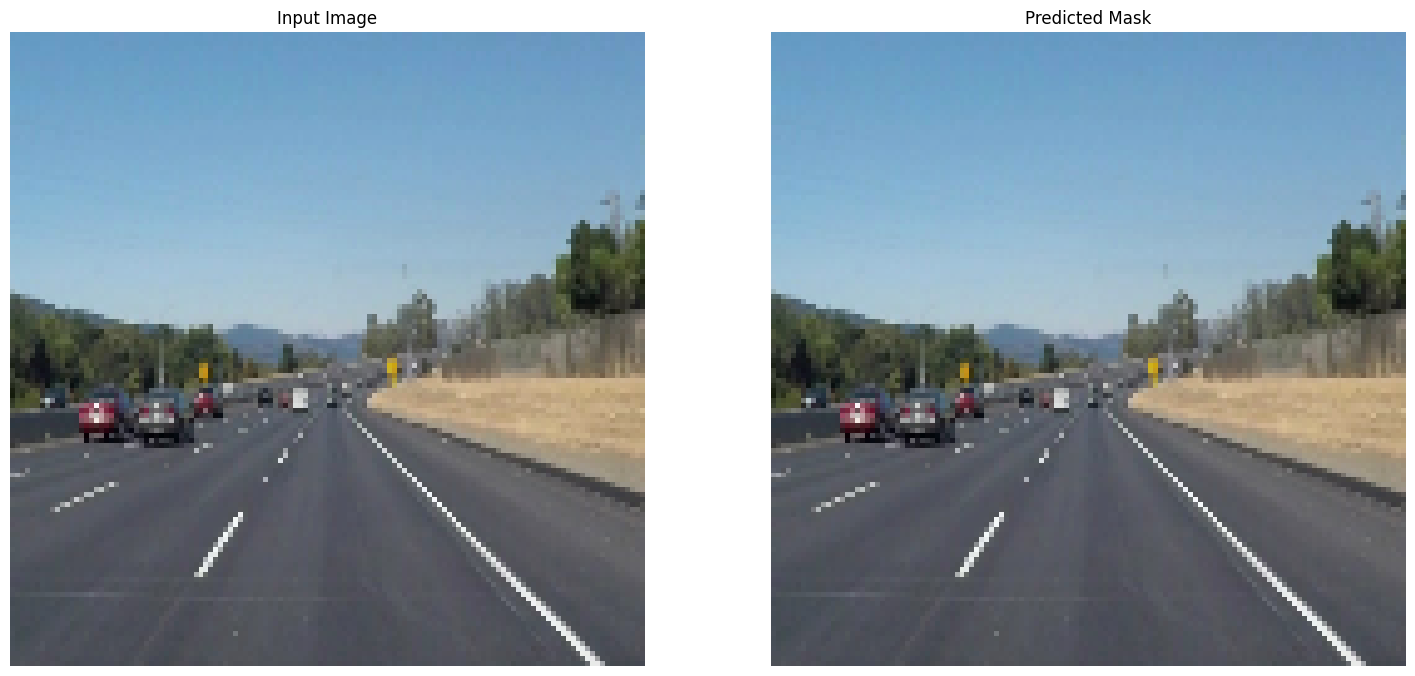

Processing image : 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


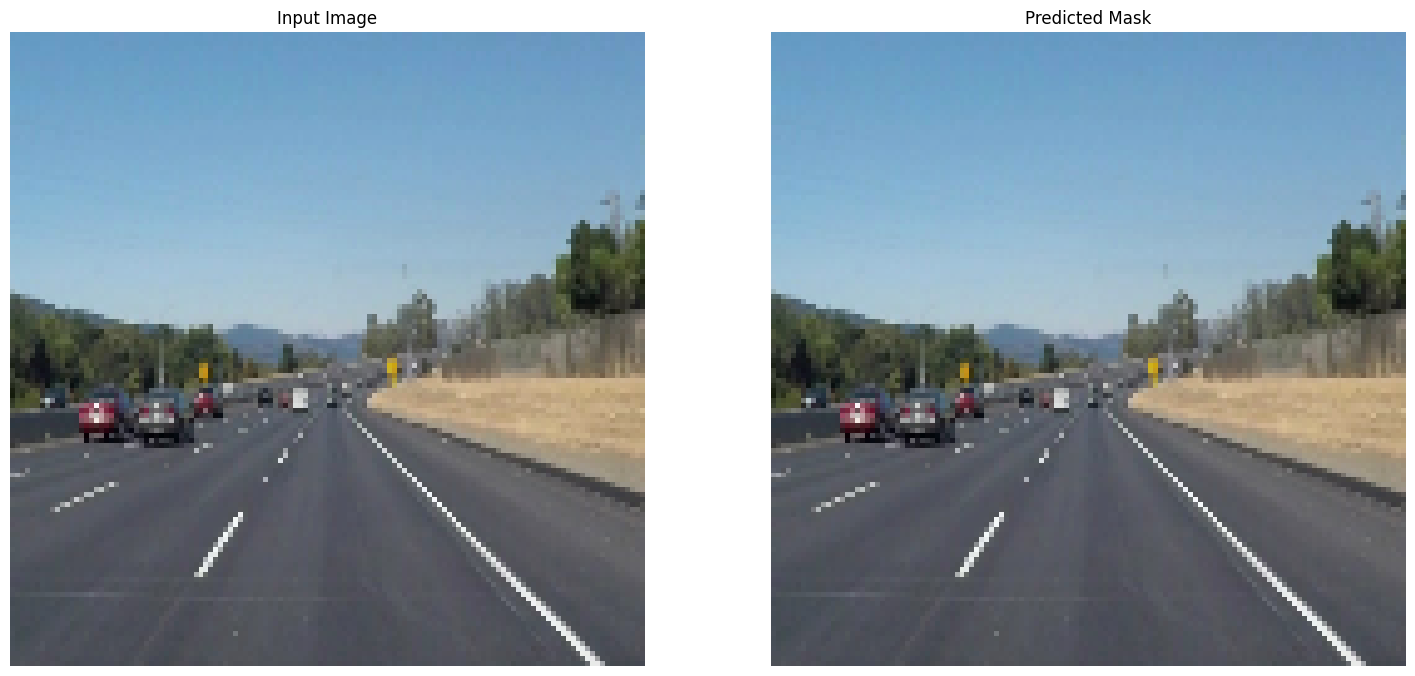

Processing image : 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


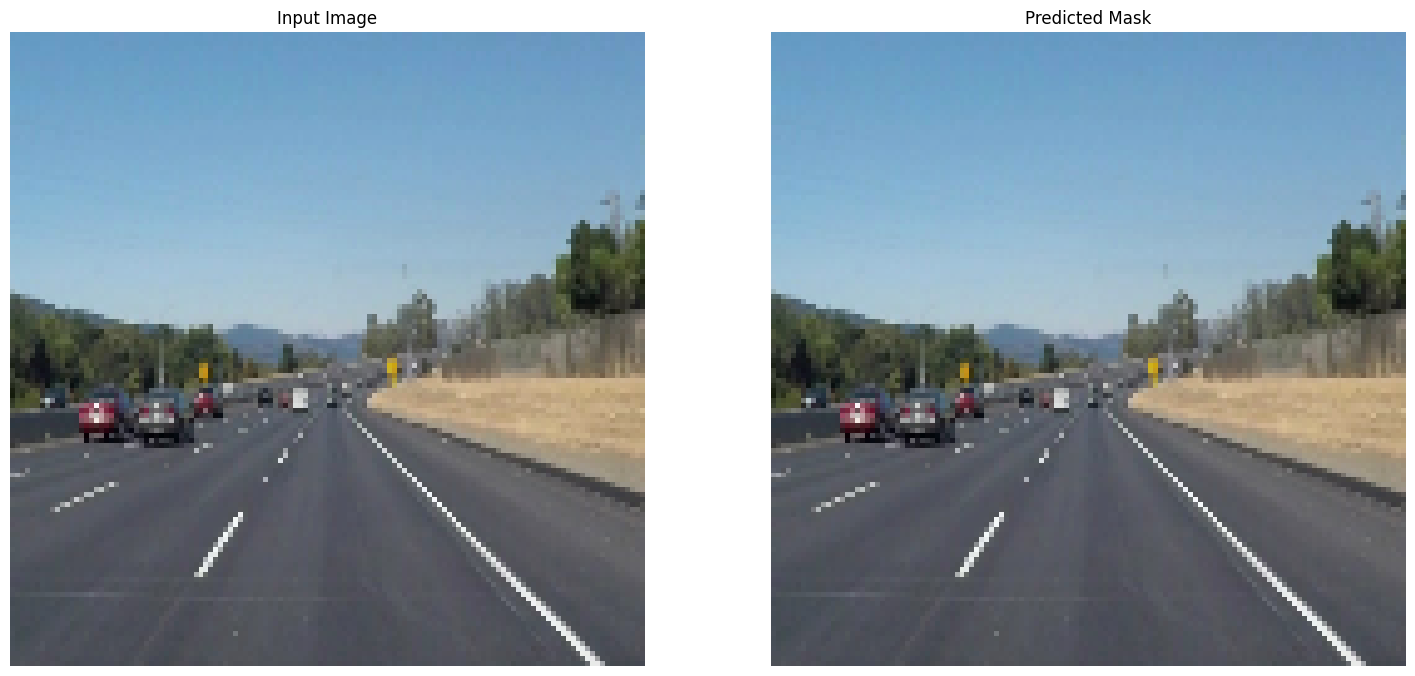

Processing image : 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


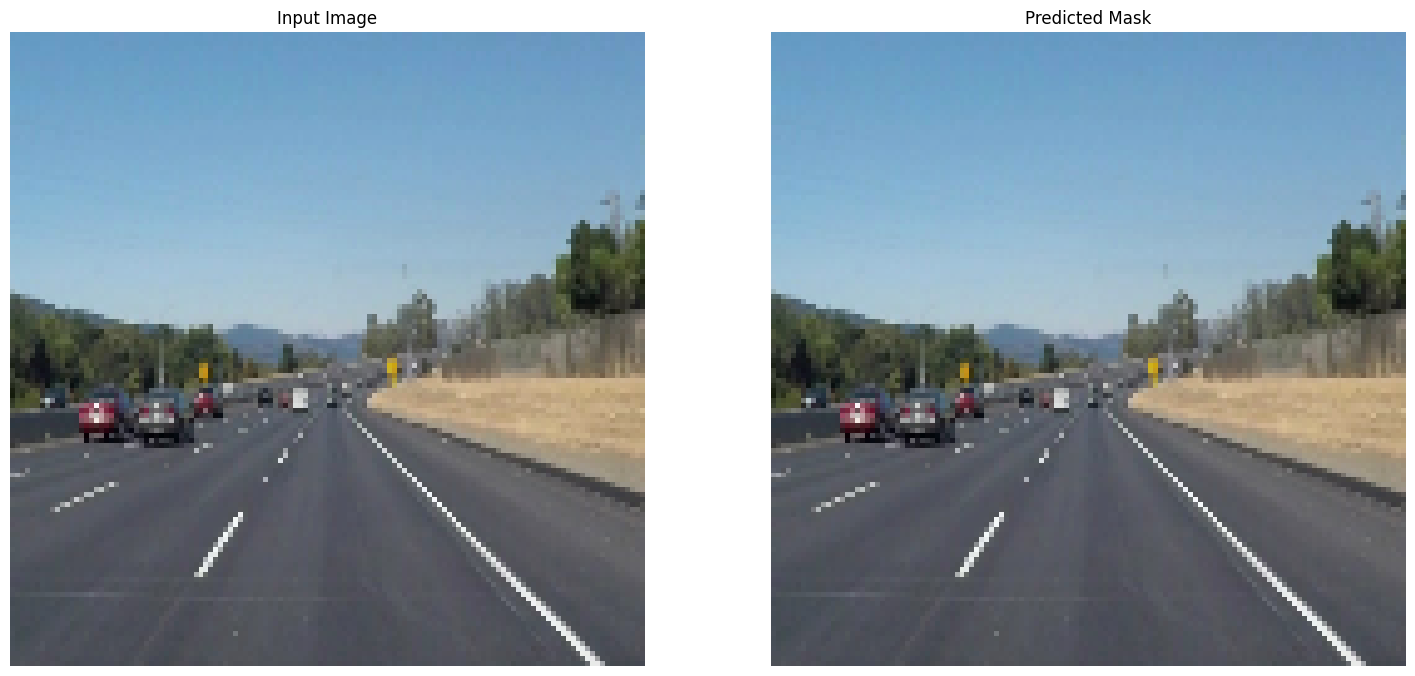

Processing image : 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


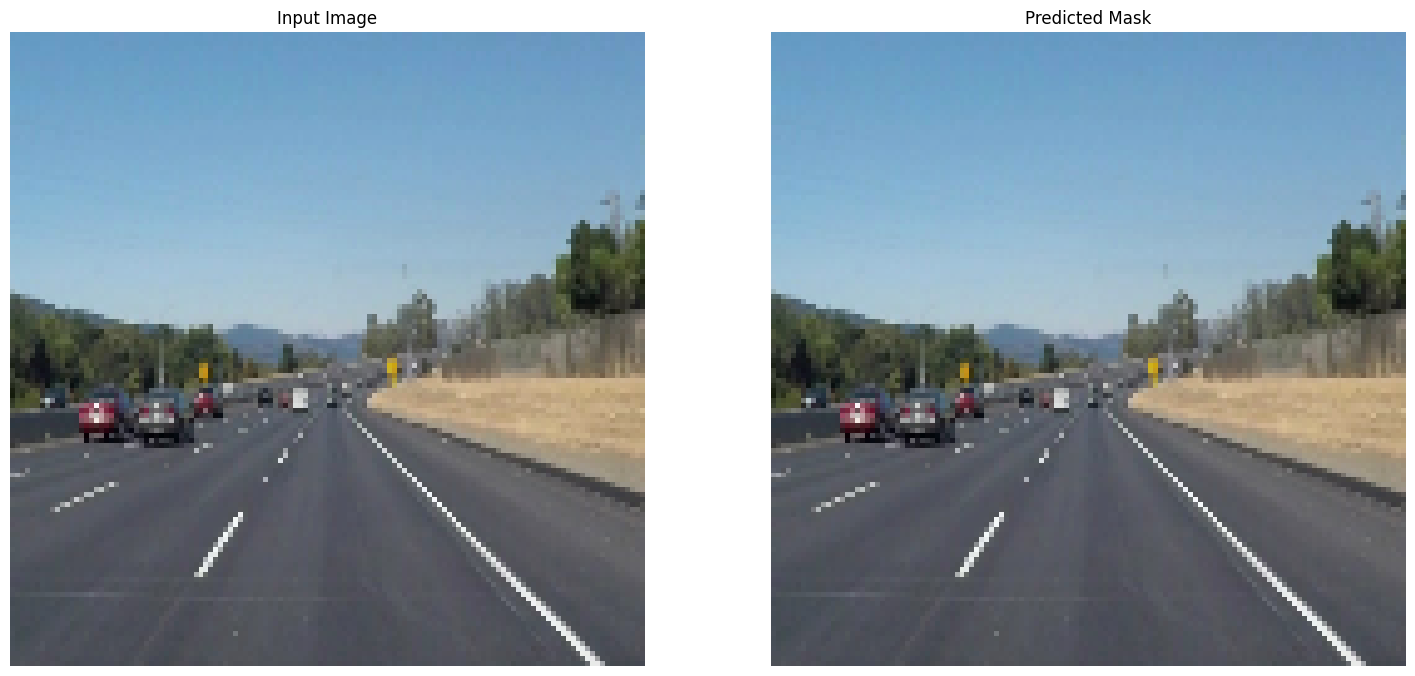

Processing image : 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


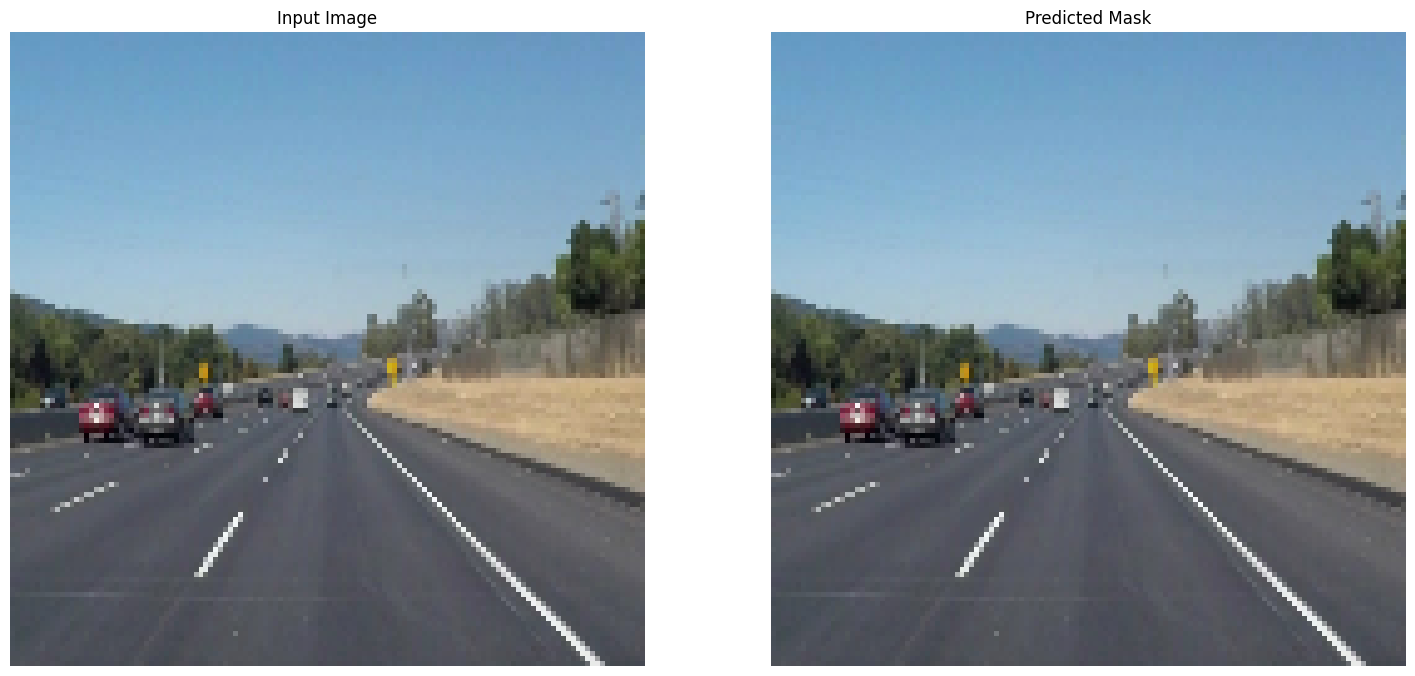

Processing image : 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


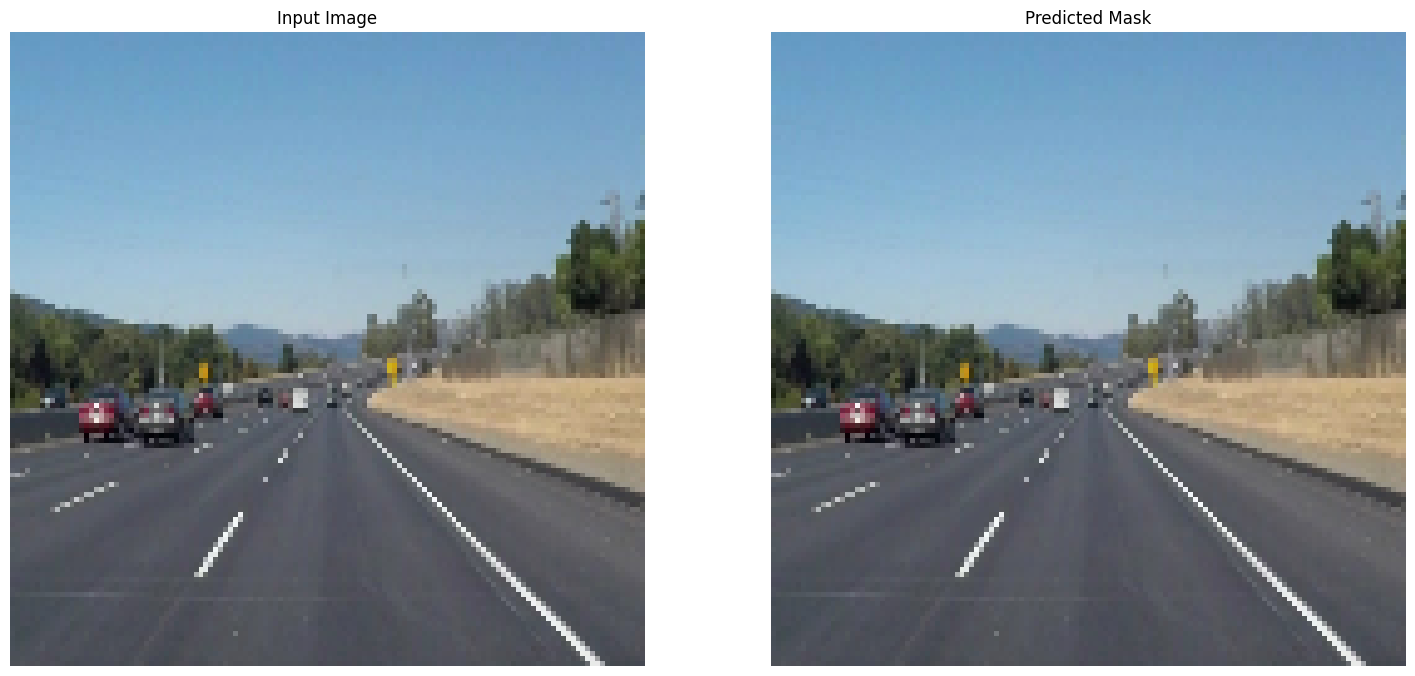

Processing image : 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


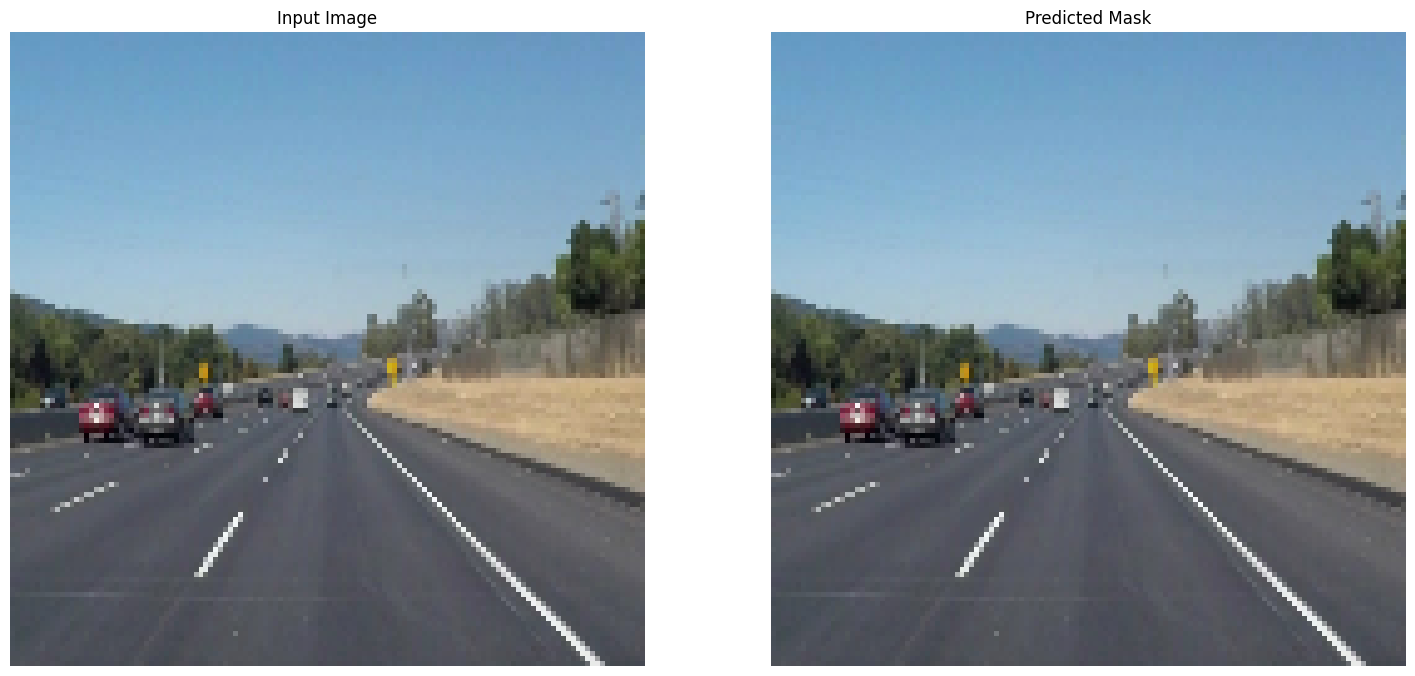

Processing image : 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


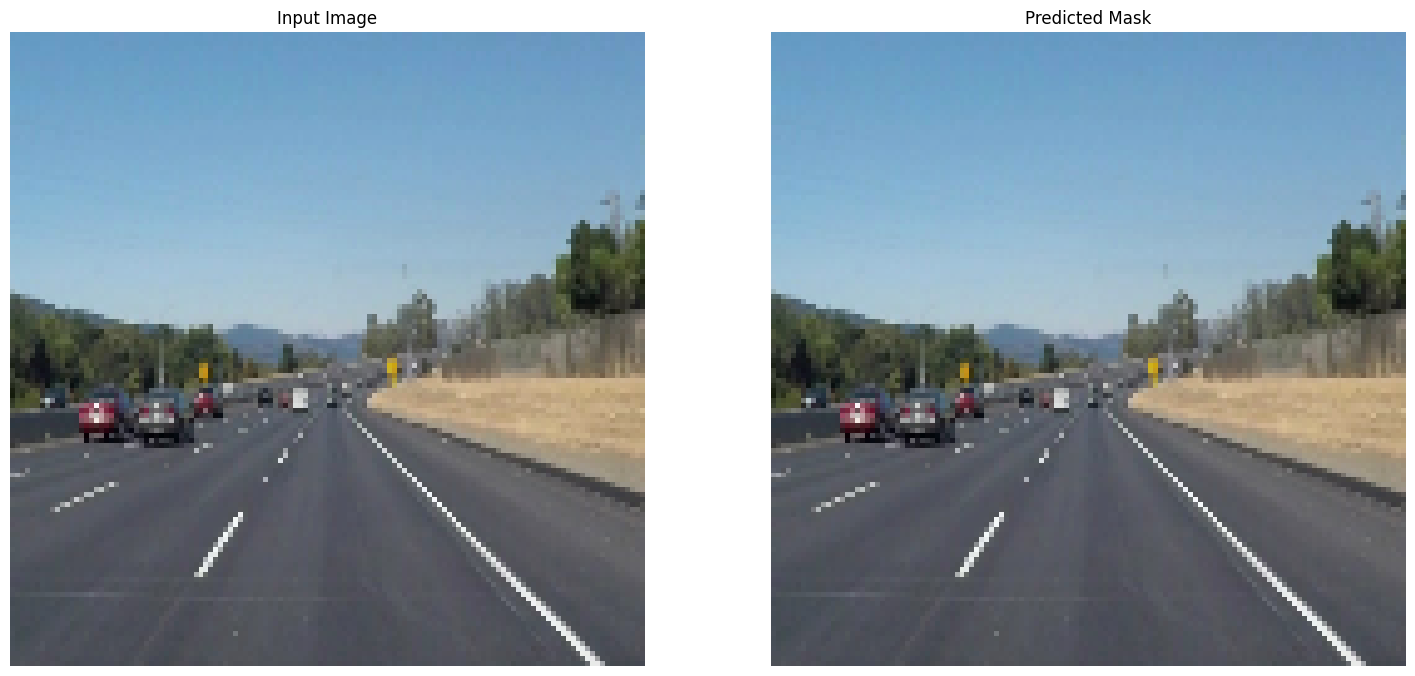

Processing image : 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


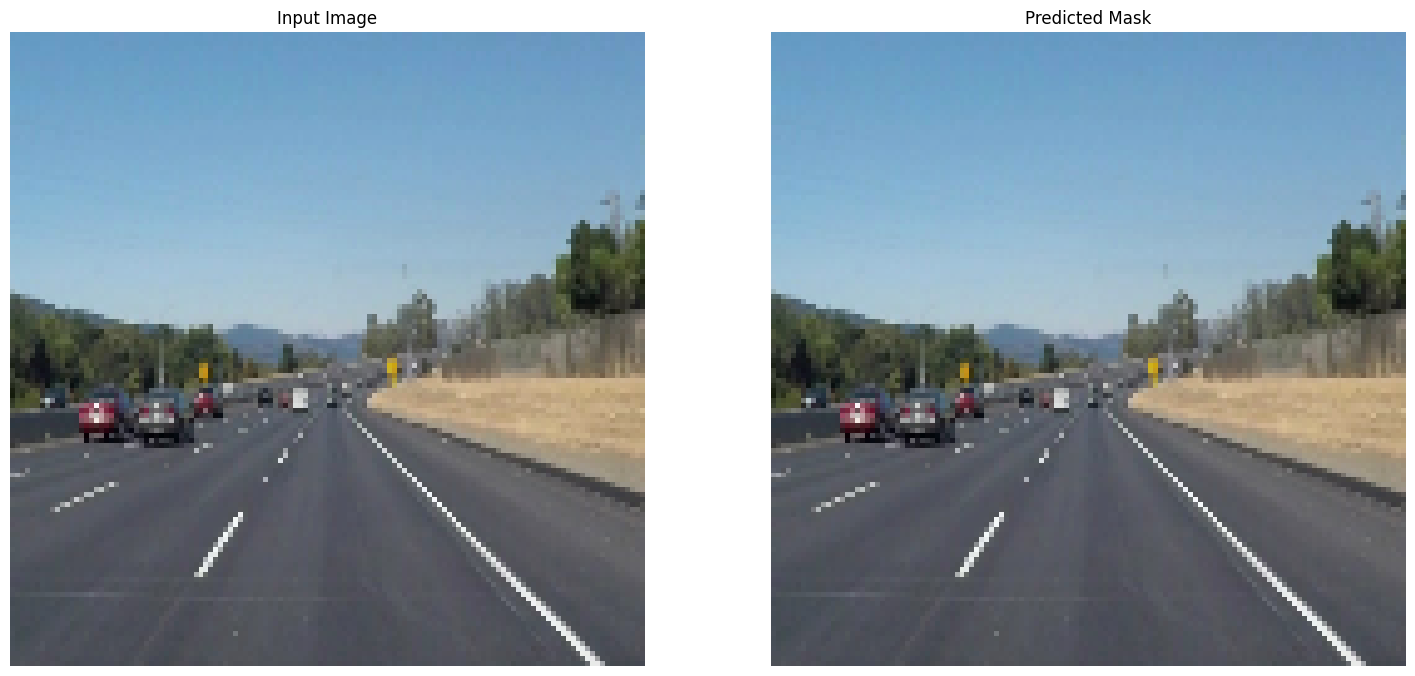

Processing image : 11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


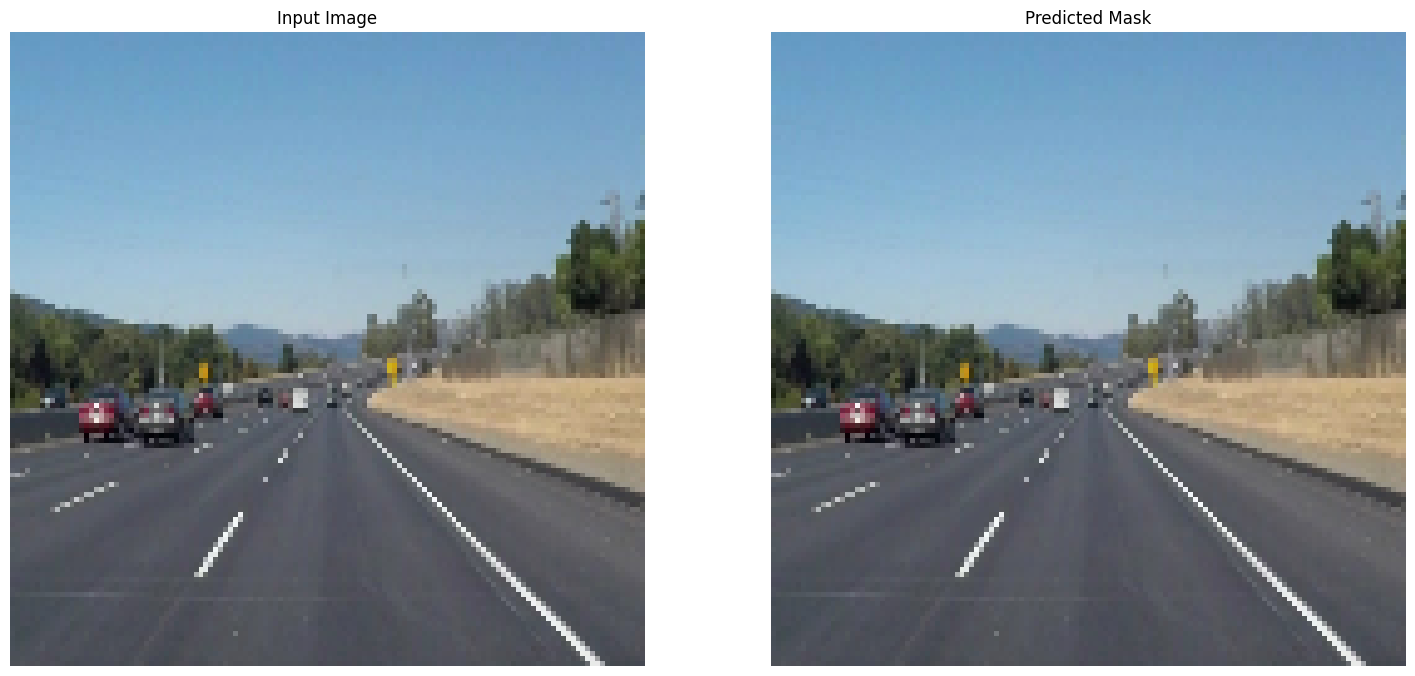

Processing image : 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


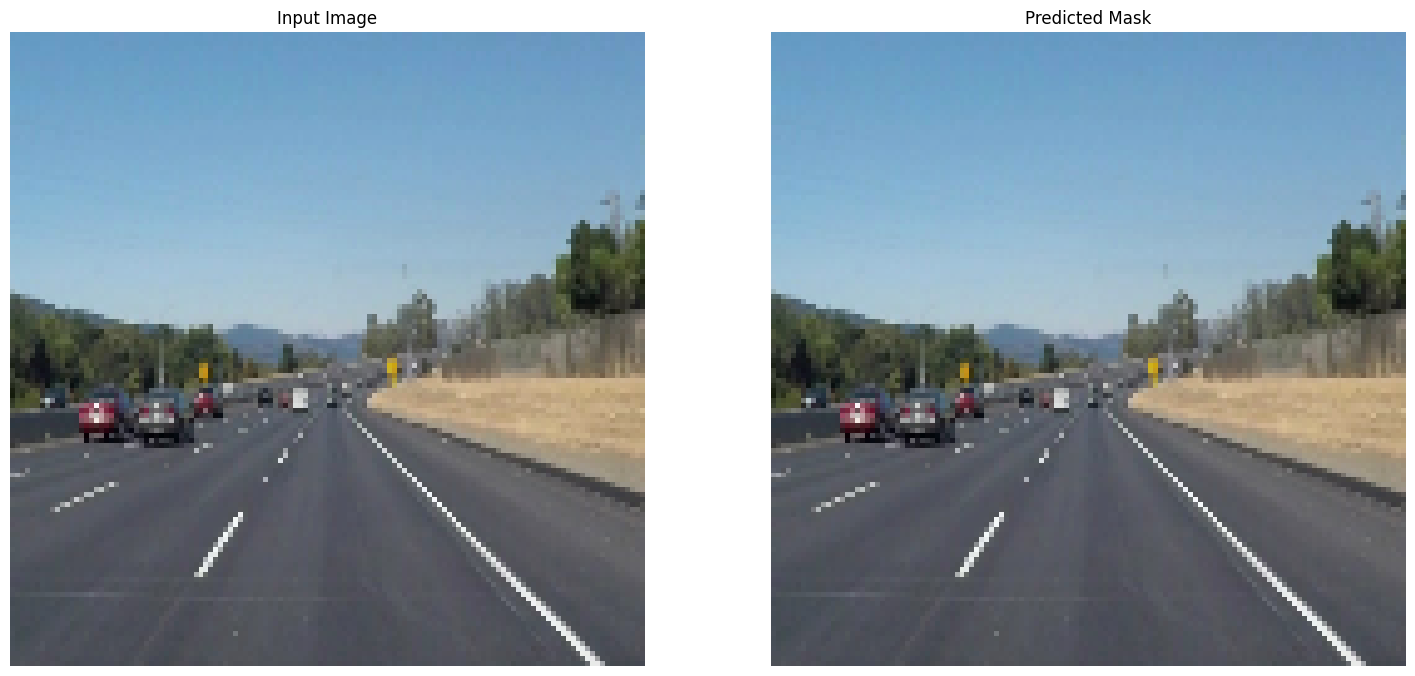

Processing image : 13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


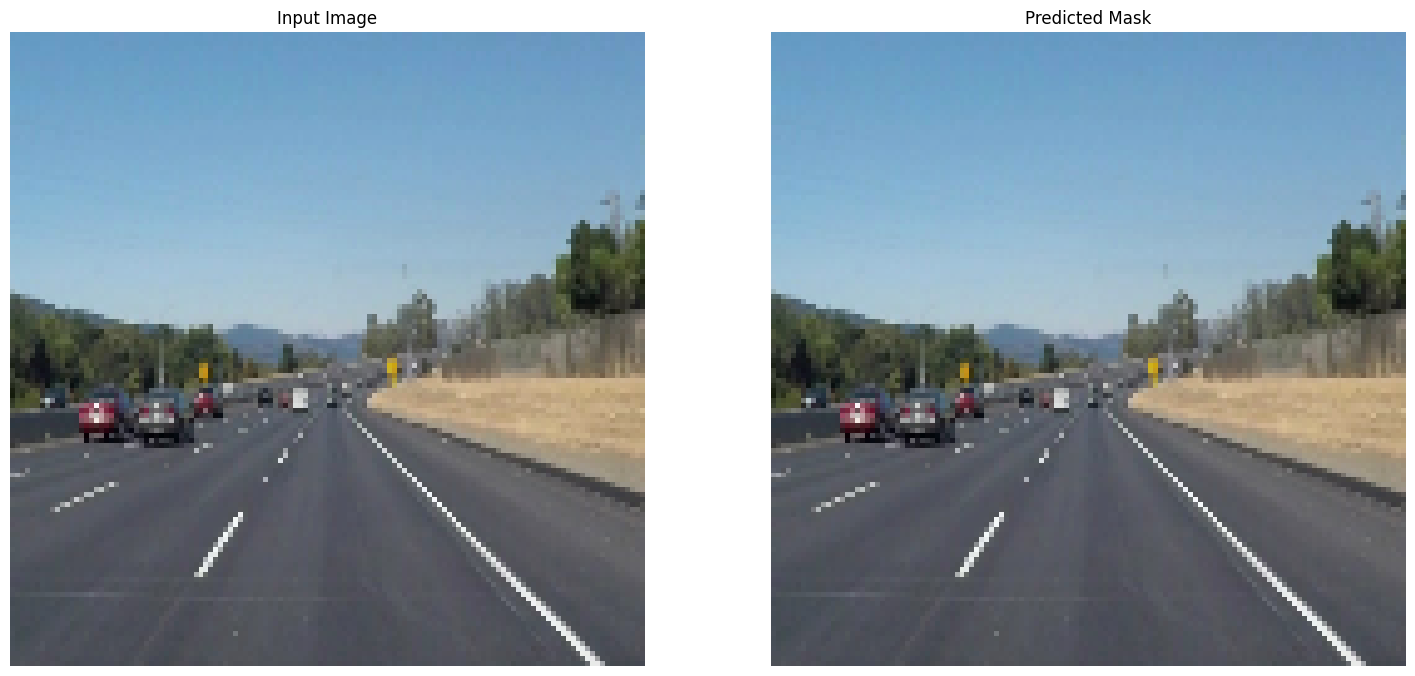

Processing image : 14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


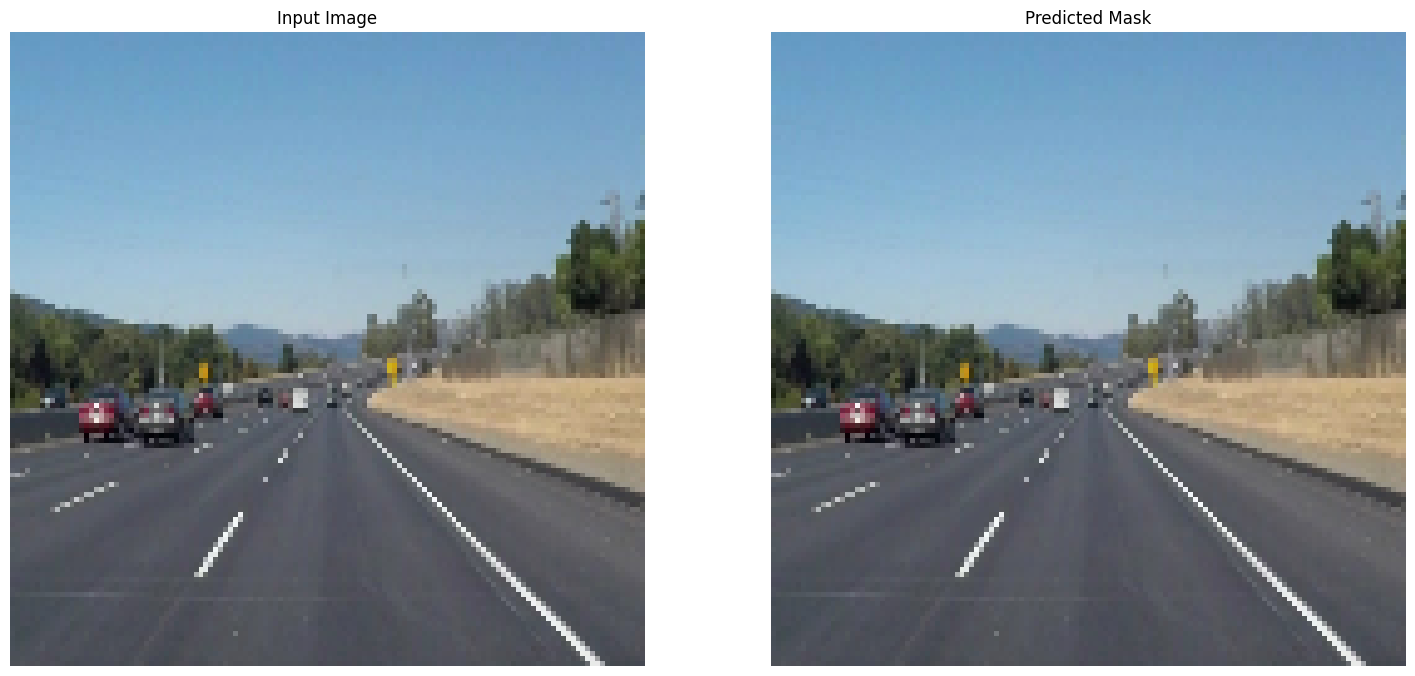

Processing image : 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


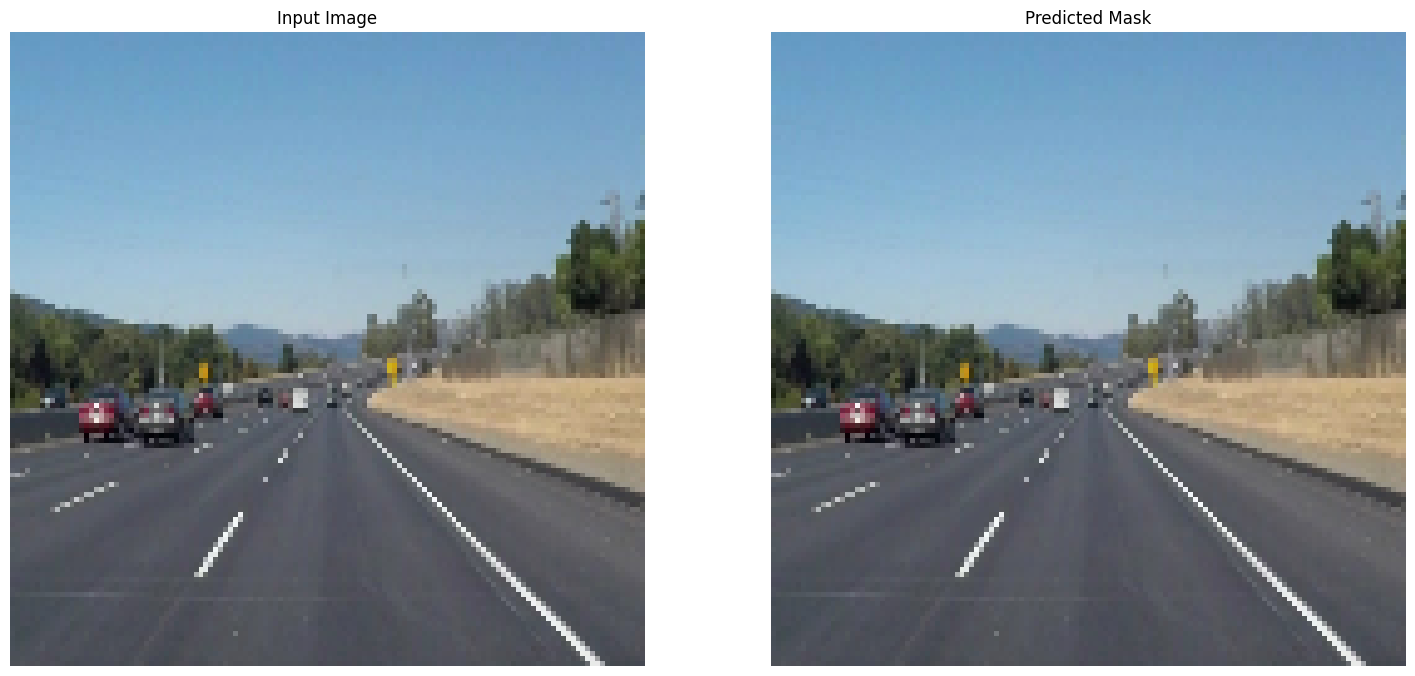

Processing image : 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


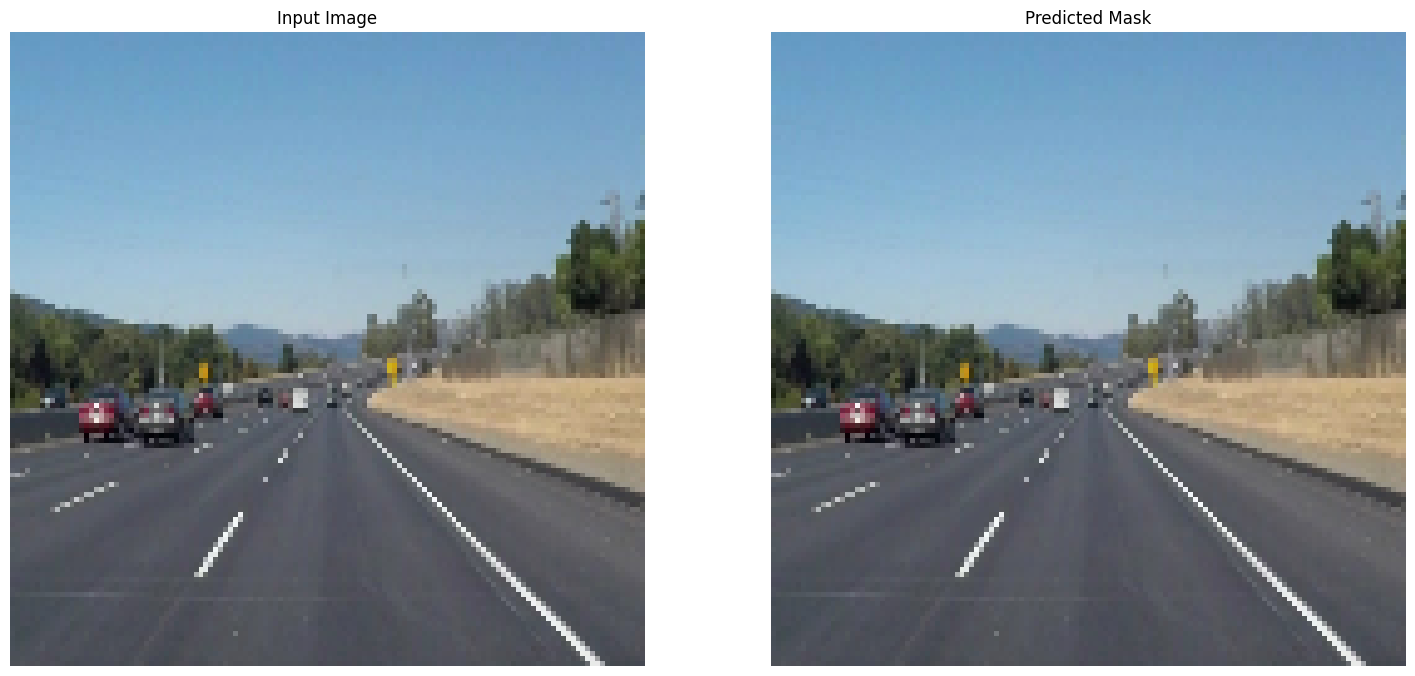

Processing image : 17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


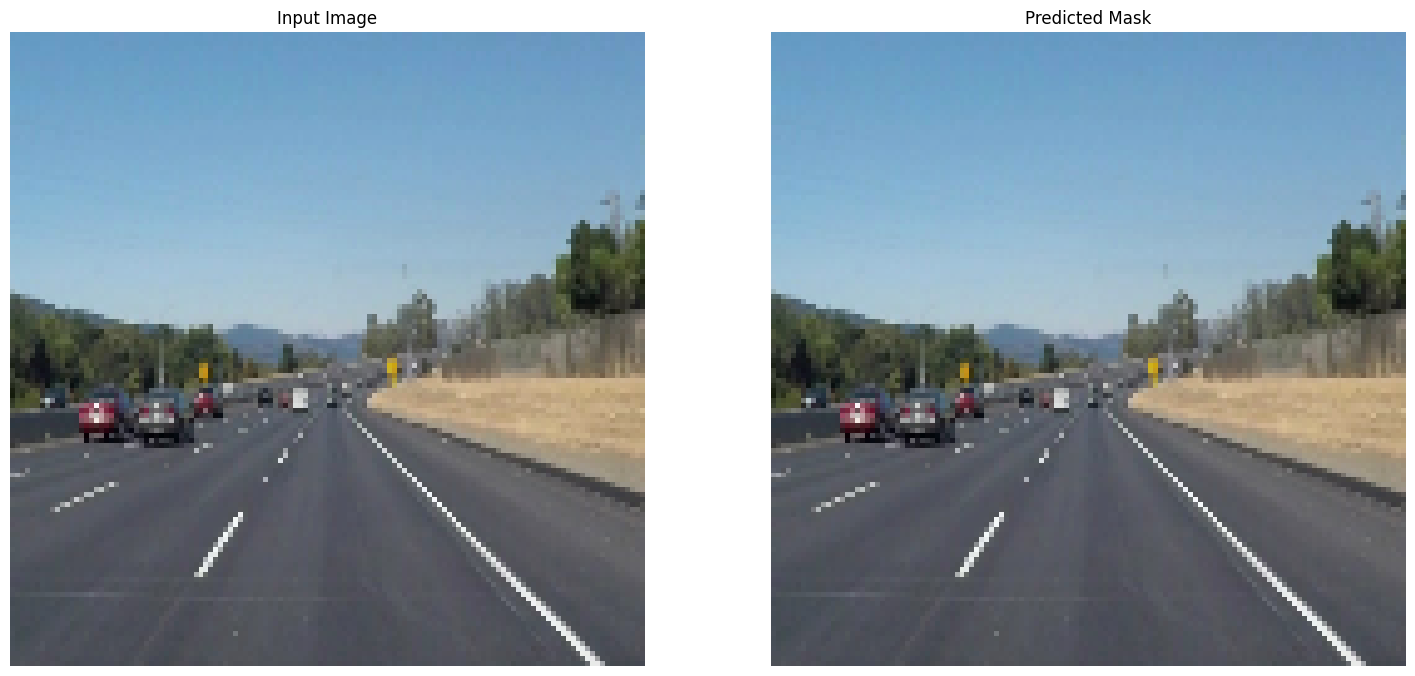

Processing image : 18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


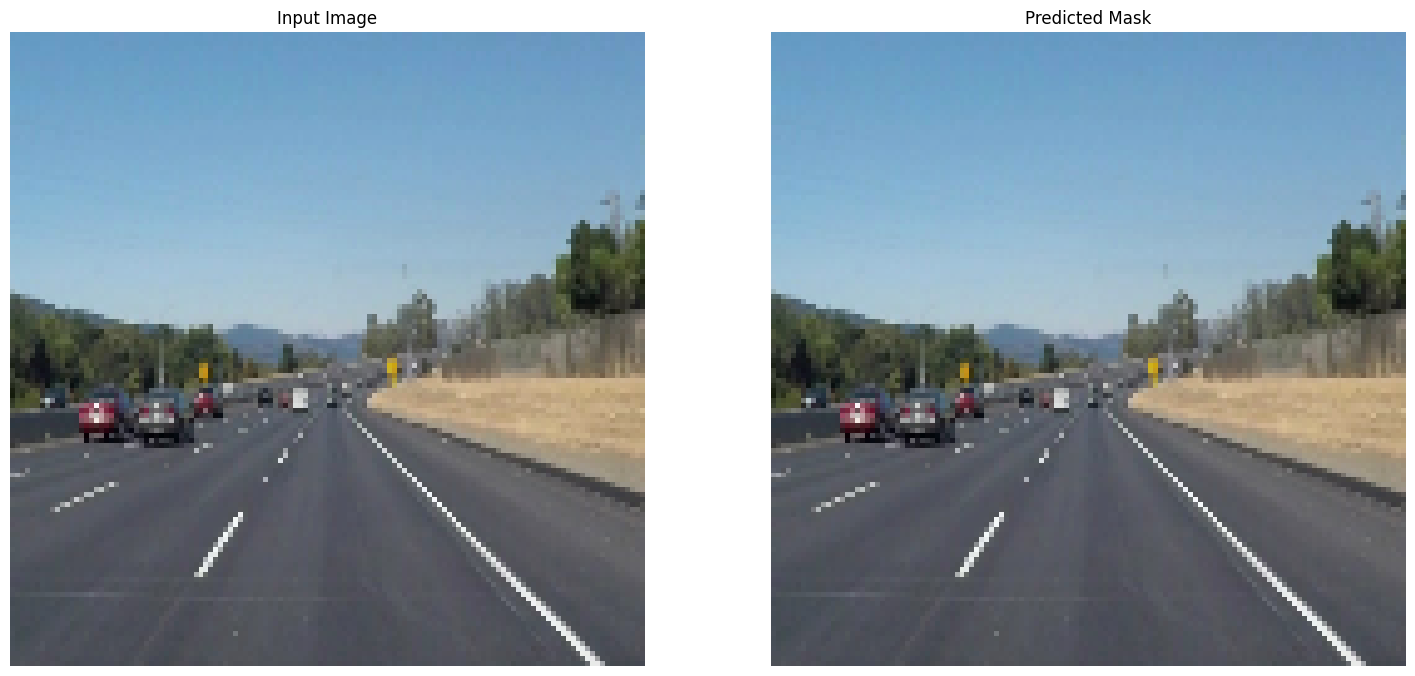

Processing image : 19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


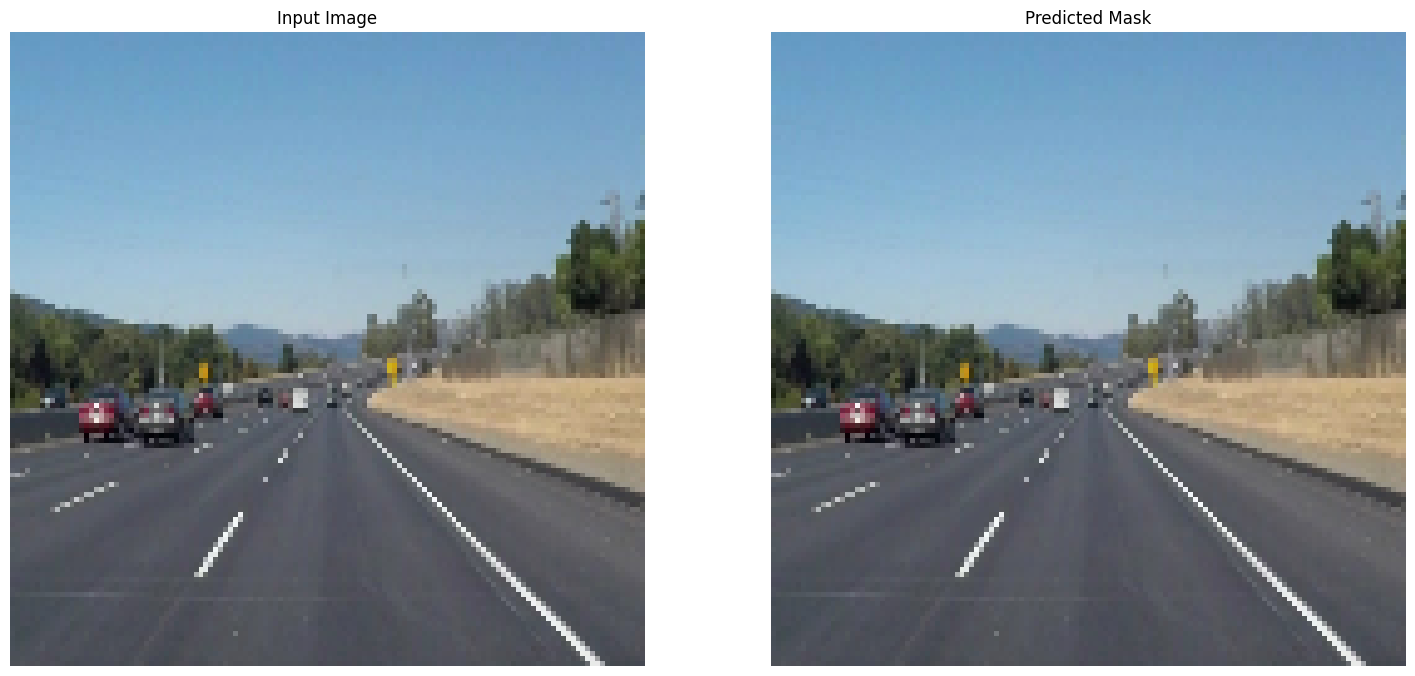

Processing image : 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


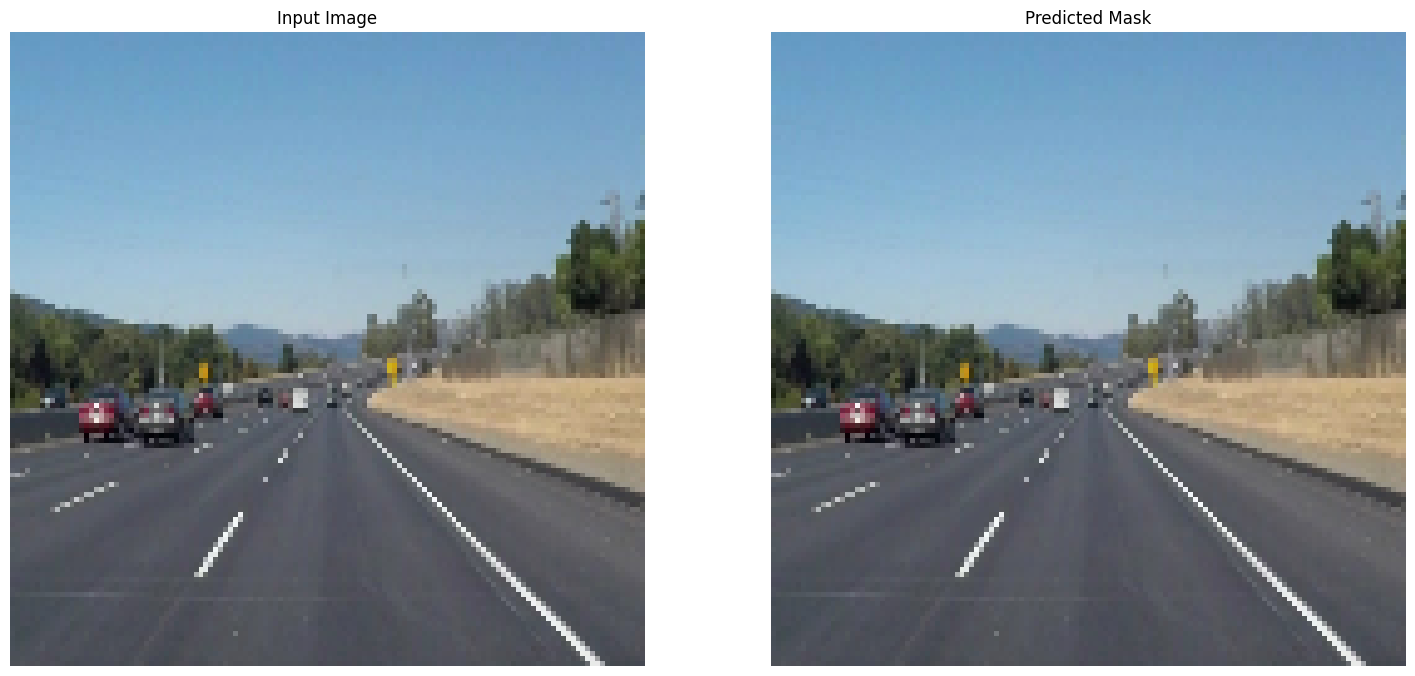

Processing image : 21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


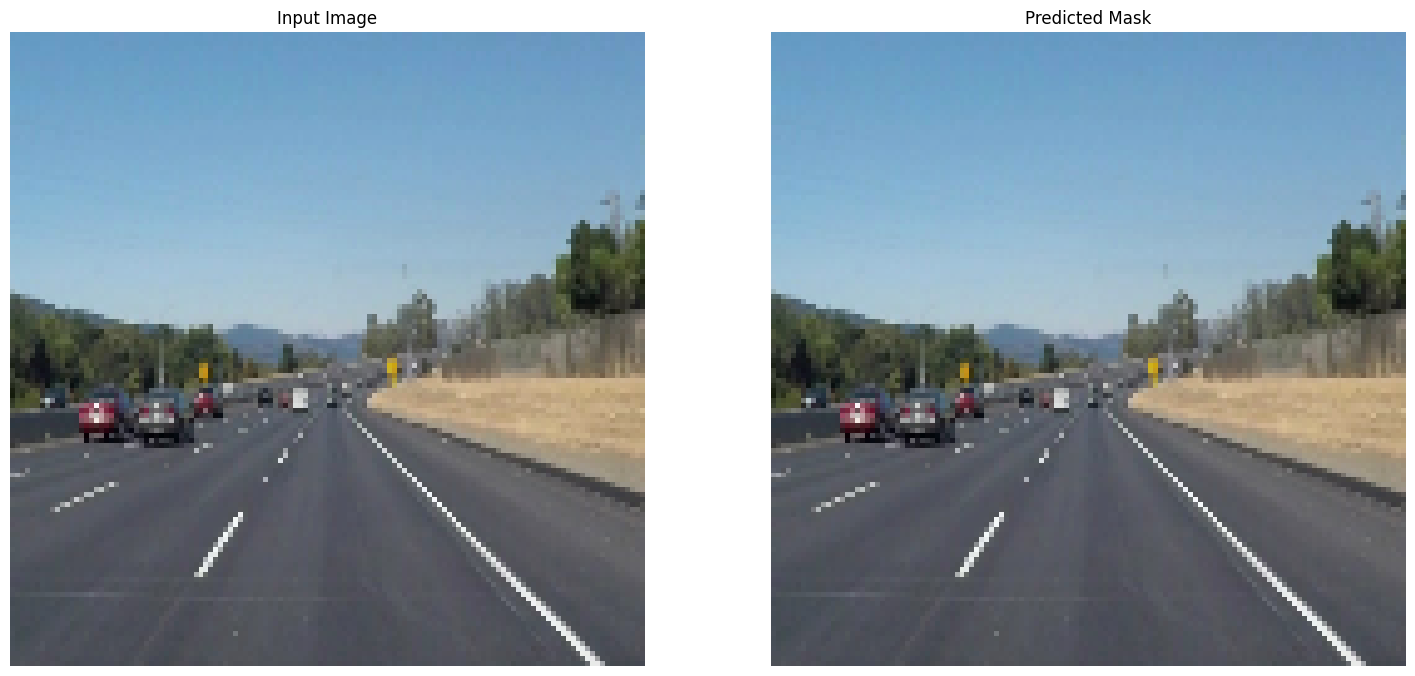

Processing image : 22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


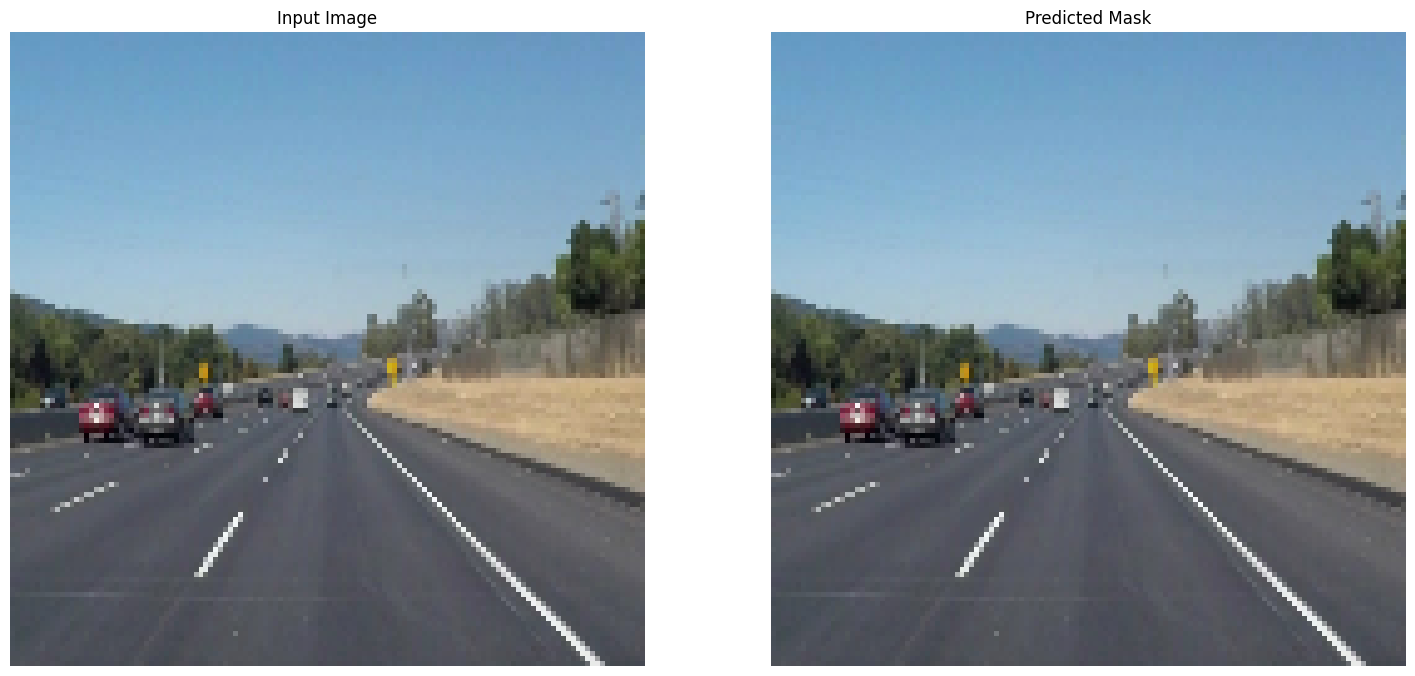

Processing image : 23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


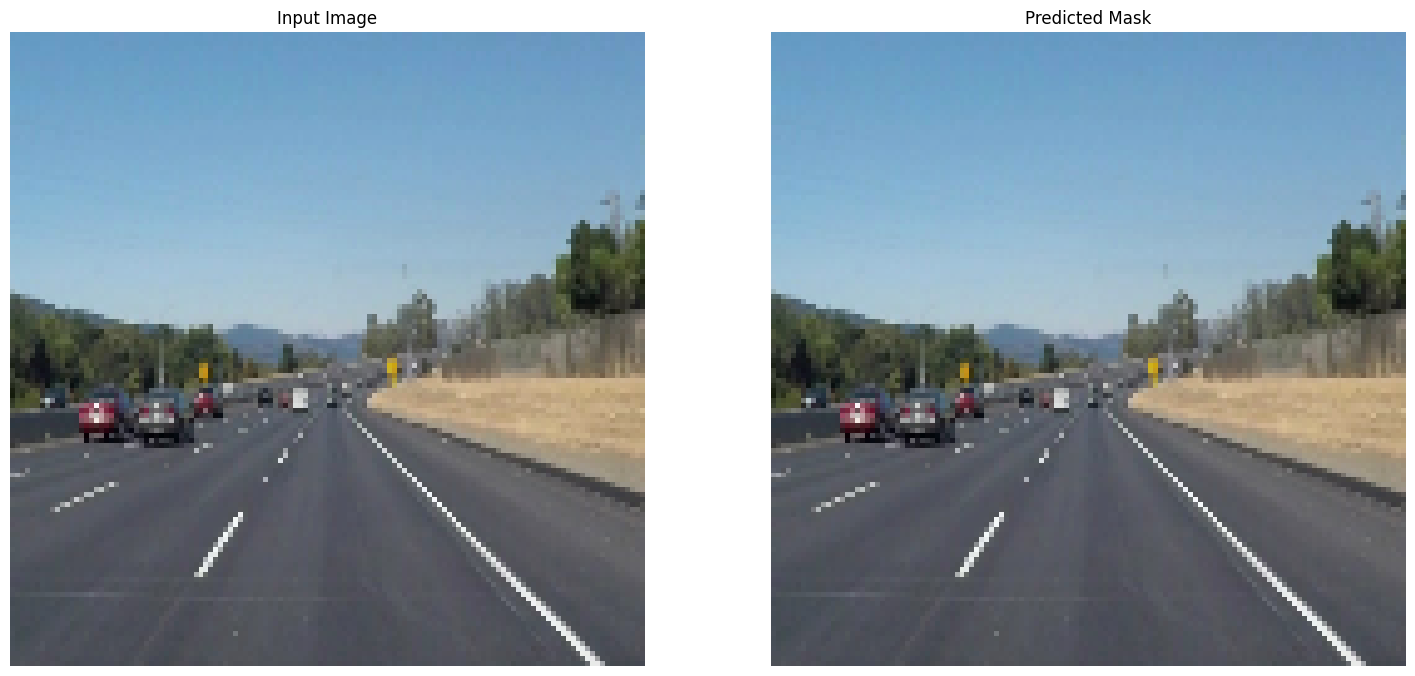

2024-05-10 13:20:08.197970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Function to save predictions
def save_predictions(dataset):
    # Predict and save image the from input dataset
    index = 0
    for batch_image, batch_mask in dataset:
        for image, mask in zip(batch_image, batch_mask):
            print(f"Processing image : {index}")
            pred_mask = model.predict(tf.expand_dims(image, axis = 0))
            save_sample([image, process_image_mask(image, pred_mask[0])], index)
            index += 1

# Function to save the images as a plot
def save_sample(display_list, index):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.savefig(f"outputs/{index}.png")
    plt.show()

os.mkdir("outputs")
save_predictions(dataset['test'])

